# PARTE 1 - Infraestrutura


In [15]:
# importando as bibliotecas necessárias

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn_extra.cluster import KMedoids
from scipy.cluster.hierarchy import dendrogram

In [16]:
#informando a versão do python e também o ambiente virtual utilizado
print(f'A versão do python instalada é: {sys.version}\nRodando no ambiente virtual: {sys.prefix}')

A versão do python instalada é: 3.13.0 | packaged by Anaconda, Inc. | (main, Oct  7 2024, 21:21:52) [MSC v.1929 64 bit (AMD64)]
Rodando no ambiente virtual: c:\Users\Alan\miniconda3\envs\clusterizacao


Este arquivo, em conjunto com o dataset, requirements.txt e um screenshot do ambiente de desenvolvimento estão no github: https://github.com/AlansAlonso/PG-IA



# PARTE 2 - Escolha de base de dados

Quantidade de Paises na base de dados:  167
Não há dados faltantes no dataset.
Não há dados duplicados no dataset.
Tipo de dados:
País                     object
Mortalidade Infantil    float64
Exportações             float64
Saúde                   float64
Importações             float64
Renda                     int64
Inflação                float64
Expectativa de vida     float64
Fertilidade             float64
PIB per capita            int64
dtype: object


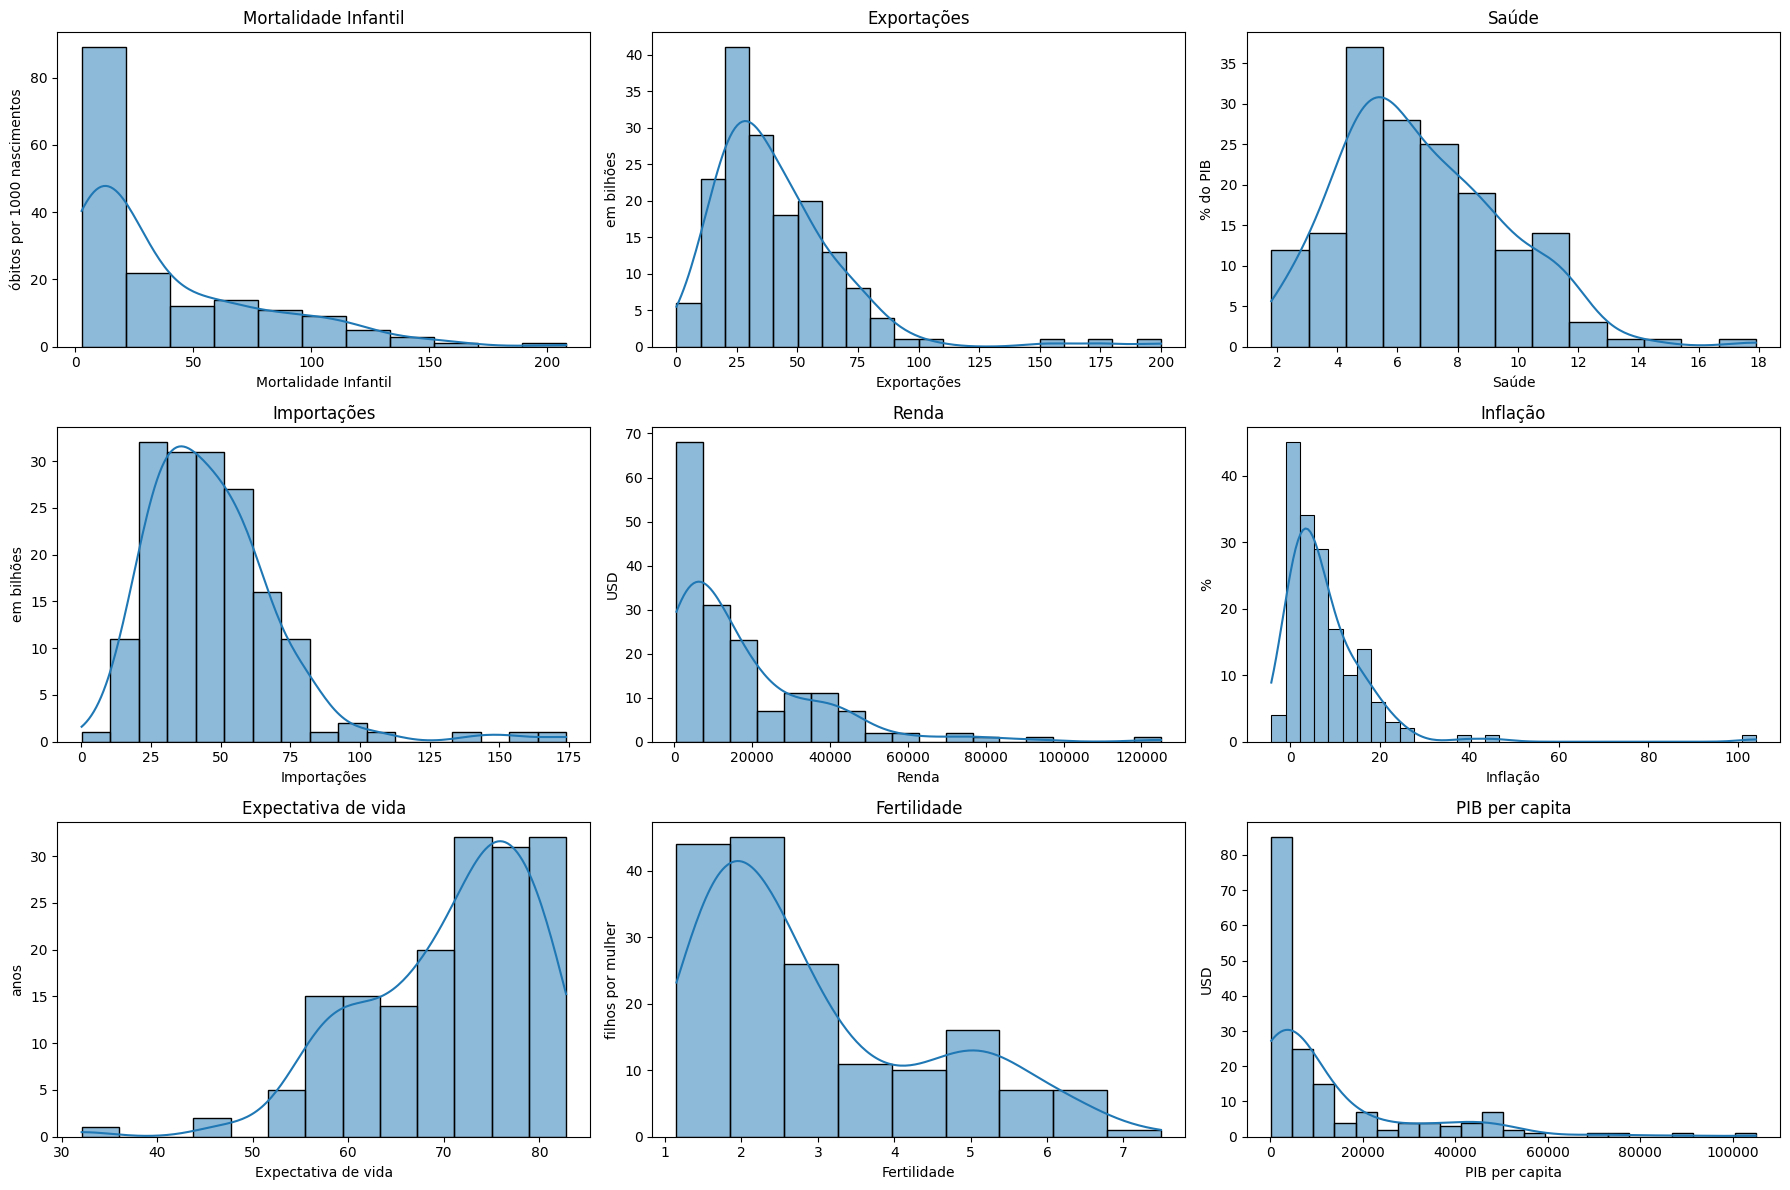

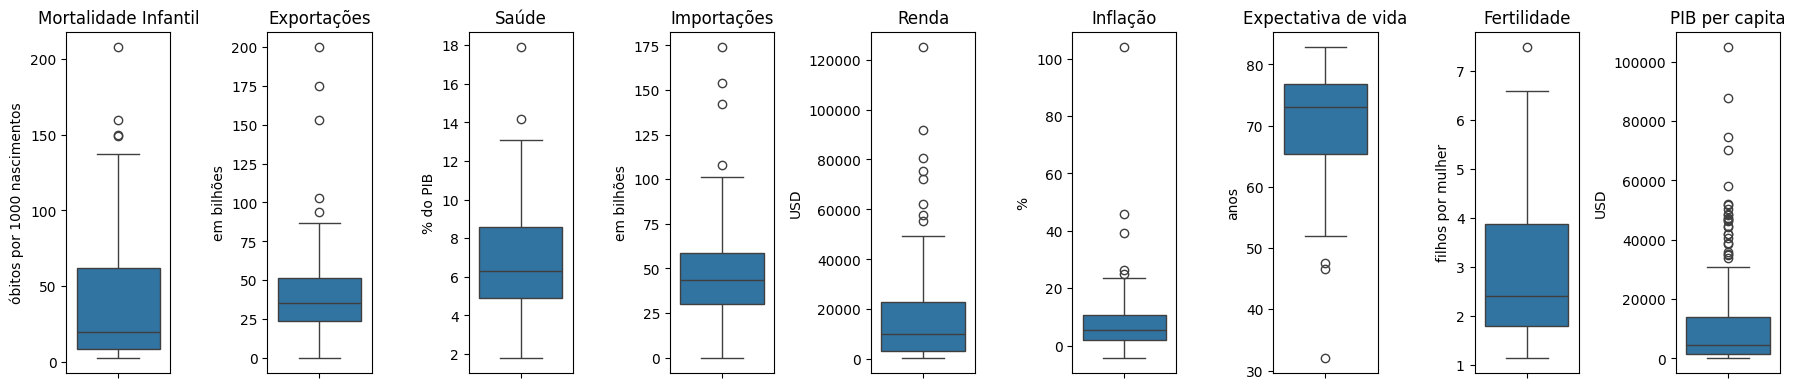

In [17]:
# lendo os dados obtidos jpá baixados da base de dados indicada
dataset = pd.read_csv('country-data.csv', sep=',', decimal='.')

# renomeando as colunas para melhor usabilidade e especificando as unidades
novos_nomes = ["País", "Mortalidade Infantil", "Exportações", "Saúde","Importações", "Renda", "Inflação", "Expectativa de vida","Fertilidade", "PIB per capita"]
unidades = ['óbitos por 1000 nascimentos', 'em bilhões', '% do PIB', 'em bilhões', 'USD', '%', 'anos', 'filhos por mulher', 'USD']

# atualizar os nomes das colunas diretamente
dataset.columns = novos_nomes

# quantos países existem no dataset?
print("Quantidade de Paises na base de dados: ", len(dataset))

# checando se há dados faltantes
if dataset.isna().sum().sum() > 0:
    print(f'Existem {dataset.isna().sum()} dados faltantes no dataset')
else:
    print("Não há dados faltantes no dataset.")

# checando se há dados duplicados
if dataset.duplicated().sum().sum() > 0:
    print(f'Existem {dataset.duplicated().sum()} dados duplicados no dataset')
else:
    print("Não há dados duplicados no dataset.")


# verificando os tipos de cada dado
print("Tipo de dados:")
print(dataset.dtypes)

# selecionando apenas as colunas numéricas para plotagem 
colunas_numericas = dataset.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(18, 12))

# plotando um histograma
for index, value in enumerate(colunas_numericas):
    plt.subplot(3, 3, index + 1)
    sns.histplot(dataset[value], kde=True)
    plt.title(value)
    plt.ylabel(unidades[index])
plt.tight_layout()

# plotando um boxplot
plt.figure(figsize=(18,4))
for index, column in enumerate(colunas_numericas):
    plt.subplot(1, 9, index+1)
    sns.boxplot(dataset[column])
    plt.title(column)
    plt.ylabel(unidades[index])
plt.tight_layout()

In [18]:
# detectando e identificando os outliers nos boxplots

def detectar_outliers(df, coluna):
    # determinando os quartis
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1

    # limites superior e inferior para outliers
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # identificando os outliers
    outliers = df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)]
    
    return outliers

# buscando os outliers em cada uma das colunas do dataset
for column in colunas_numericas:
    outliers = detectar_outliers(dataset, column)
    
    if not outliers.empty:
        print(f'Outliers para a variável {column}:')
        for _, row in outliers.iterrows():
            print(f"País: {row['País']} - Valor da variável: {row[column]}")
        print('-' * 60)


Outliers para a variável Mortalidade Infantil:
País: Central African Republic - Valor da variável: 149.0
País: Chad - Valor da variável: 150.0
País: Haiti - Valor da variável: 208.0
País: Sierra Leone - Valor da variável: 160.0
------------------------------------------------------------
Outliers para a variável Exportações:
País: Ireland - Valor da variável: 103.0
País: Luxembourg - Valor da variável: 175.0
País: Malta - Valor da variável: 153.0
País: Seychelles - Valor da variável: 93.8
País: Singapore - Valor da variável: 200.0
------------------------------------------------------------
Outliers para a variável Saúde:
País: Micronesia, Fed. Sts. - Valor da variável: 14.2
País: United States - Valor da variável: 17.9
------------------------------------------------------------
Outliers para a variável Importações:
País: Luxembourg - Valor da variável: 142.0
País: Malta - Valor da variável: 154.0
País: Seychelles - Valor da variável: 108.0
País: Singapore - Valor da variável: 174.0
-

Com os dados obtidos no boxplot anterior, achei que seria interessante buscar que países estavam sendo outliers em quais variáveis. Em especial, alguns países com características muito específicas como Luxembourg foram outliers recorrentes, sugerindo um padrão de exceção. Além disso, vê-se que em especial o PIB per capita teve muitos outliers, também podemos analisar a importância dessa coluna em nossa base de dados.

Agora, para que possamos utilizar esses dados em uma clusterização, precisamos impedir que a diferença de escala atrapalhe o nosso projeto. Por exemplo, enquanto a inflação tem uma ou duas ordens de grandeza, valores como o PIB per capita podem chegar a 5 ordens de grandeza. Para resolver isso, podemos fazer uma normalização, com o MinMaxScaler, que ajusta todos os números entre 0 e 1, ou uma padronização com StandardScaler, onde os números serão ajustados de forma que a média será 0 e o desvio padrão igual a 1

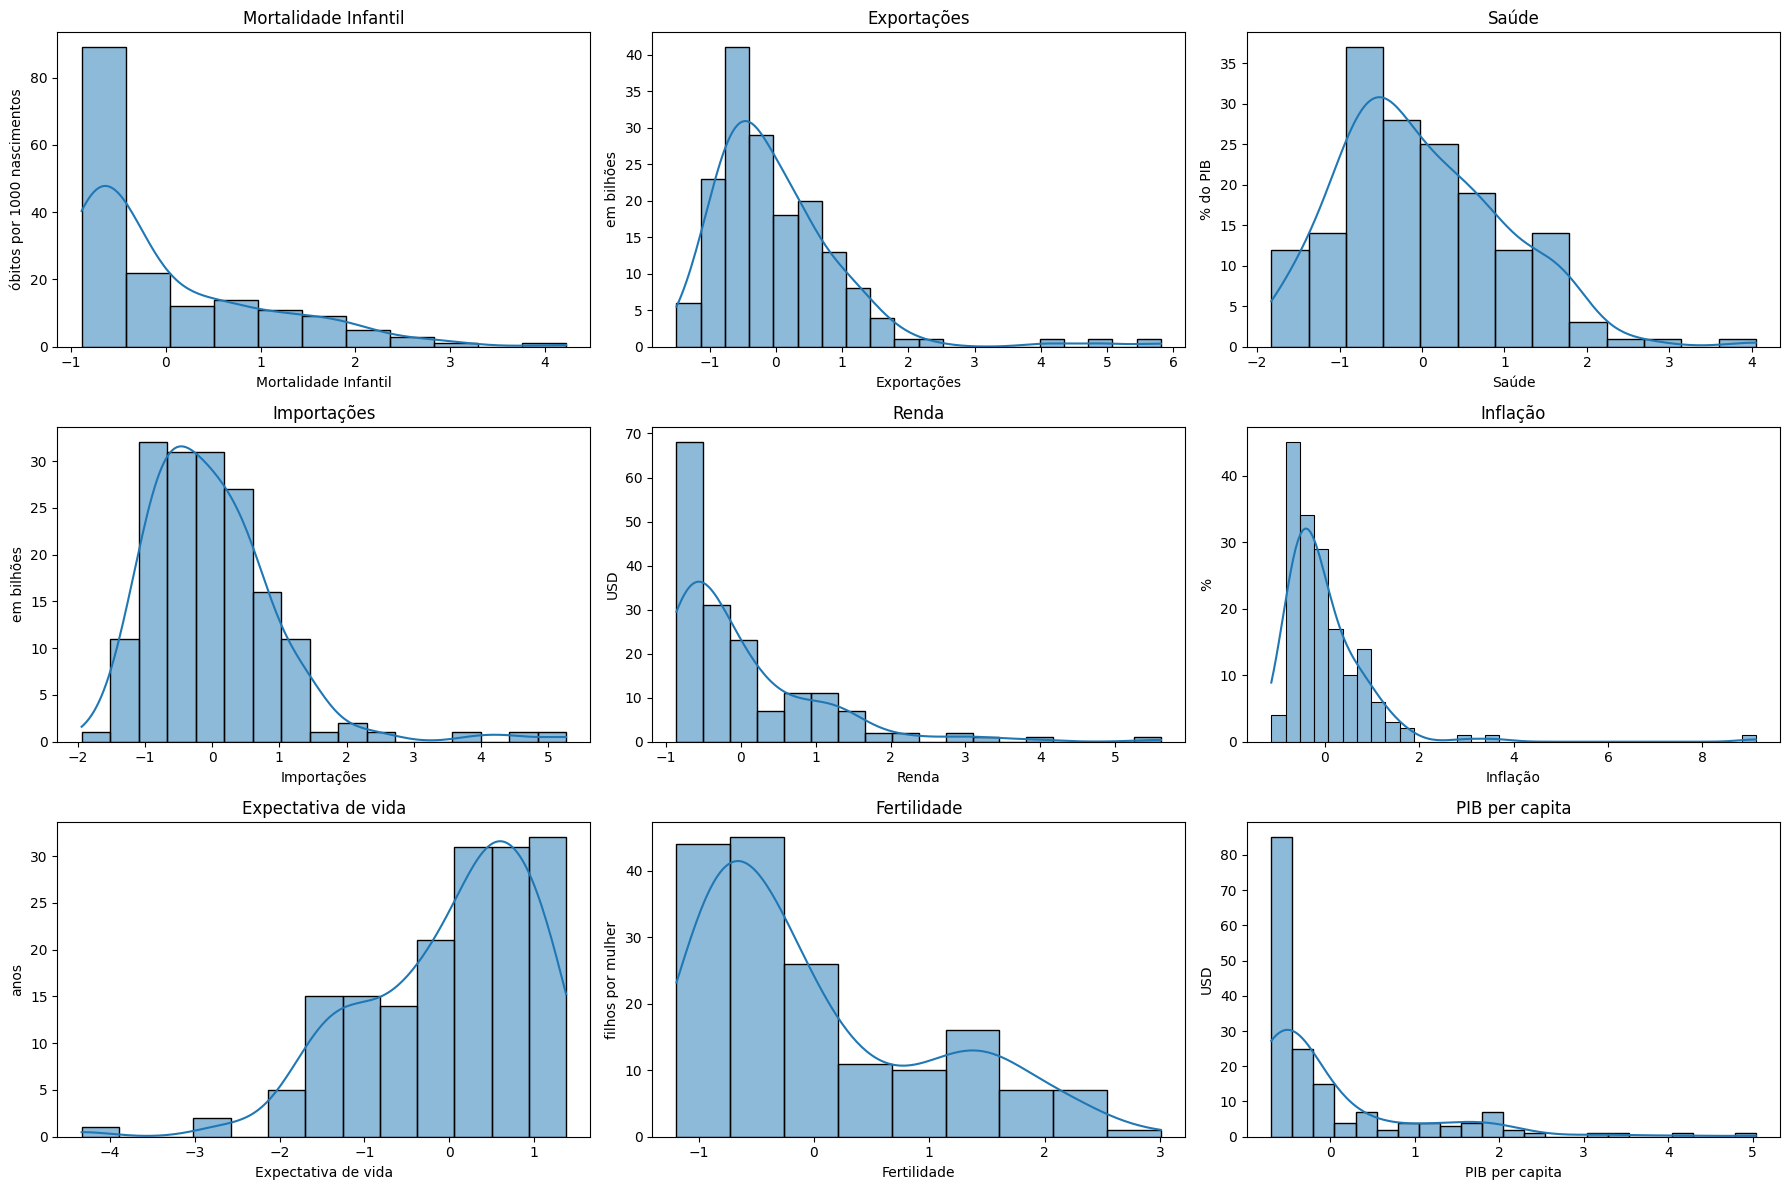

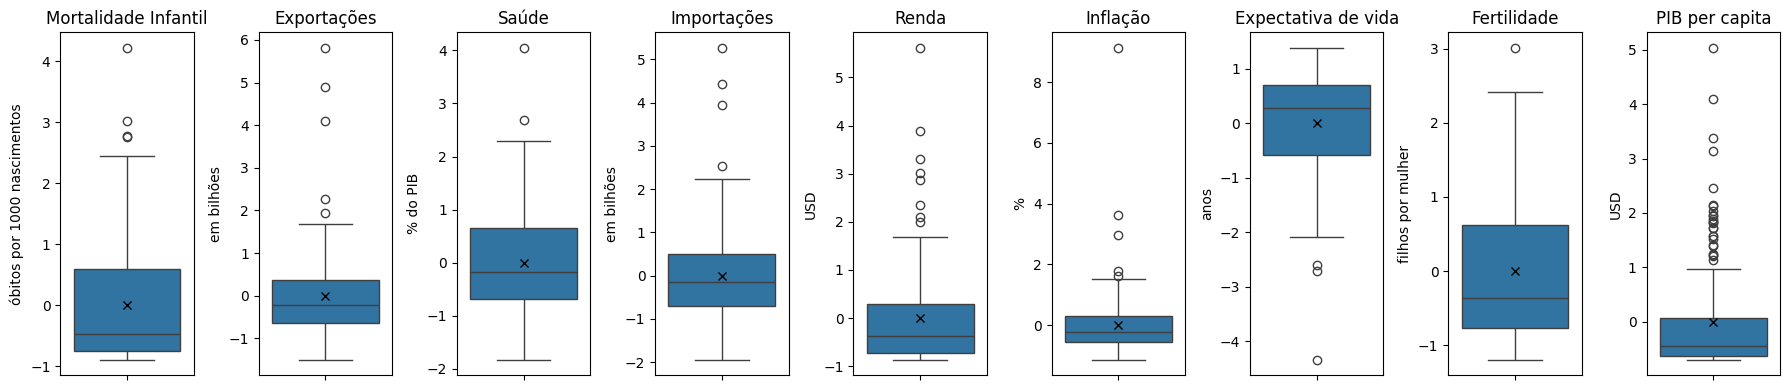

In [19]:
# Foi decidido por uma padronização dos dados utilizando StandardScaler em detrimento de uma normalização com MinMaxScaler
# dentre os motivos a falta de necessidade de normalizar os valores entre 0 e 1 e a inexistência de um limite inferior e 
# superior em muitos desses dados, que dessem um sentido físico à possível normalização. 
# Além disso, StandardScaler é recomendada no uso de k-means

scaler = StandardScaler()
scaler.fit(dataset[colunas_numericas])
dataset_tratado = scaler.transform(dataset[colunas_numericas])

# nomeando as colunas do dataset tratado
dataset_tratado  = pd.DataFrame(dataset_tratado, columns=colunas_numericas)

# fazendo o plot dos novos valores padronizados
plt.figure(figsize=(18, 12))

for index, value in enumerate(dataset_tratado[colunas_numericas]):
    plt.subplot(3, 3, index + 1)
    sns.histplot(dataset_tratado[value], kde=True)
    plt.title(value)
    plt.ylabel(unidades[index])
plt.tight_layout()

plt.figure(figsize=(18,4))
for index, column in enumerate(dataset_tratado[colunas_numericas]):
    plt.subplot(1, 9, index+1)
    sns.boxplot(dataset_tratado[column],showmeans=True,meanprops={"marker":"x", "markeredgecolor":"black"})
    plt.title(column)
    plt.ylabel(unidades[index])
plt.tight_layout()


Especialmente interessante observar nestes gráficos de boxplot que a média, marcada por um "x" é sempre igual a 0, por definição do uso de StandardScaler.


# PARTE 3 - Clusterização

In [20]:
# realizar a clusterização dos países com base em 3 grupos e definindo uma seed

kmeans = KMeans(n_clusters=3,random_state=11)
modelo = kmeans.fit(dataset_tratado)
grupos_kmeans = kmeans.predict(dataset_tratado)

# determinação dos clusters
clusters_paises = pd.DataFrame(grupos_kmeans, columns={0: 'Agrupamento'})
clusters_paises = clusters_paises.rename(columns={0: 'Agrupamento'})                       

# adicionando novamente o nome dos países ao resultado do k-means
clusters_paises['Pais'] = dataset['País']

clusters_paises = clusters_paises.sort_values(by='Agrupamento')
pd.set_option('display.max_rows', None)
print(clusters_paises)



     Agrupamento                            Pais
1              0                         Albania
2              0                         Algeria
5              0                       Argentina
4              0             Antigua and Barbuda
6              0                         Armenia
13             0                        Barbados
10             0                         Bahamas
9              0                      Azerbaijan
14             0                         Belarus
12             0                      Bangladesh
21             0                        Botswana
22             0                          Brazil
20             0          Bosnia and Herzegovina
19             0                         Bolivia
18             0                          Bhutan
16             0                          Belize
30             0                      Cape Verde
24             0                        Bulgaria
27             0                        Cambodia
51             0    

In [21]:
### com base nos clusters observados podemos encontrar certos padrões e nomear cada cluster para que tenha um significado semântico melhor
# grupo 0 - Economias Emergentes
# grupo 1 - Economias em Vulnerabilidade
# grupo 2 - Economias Avançadas

nomes_grupos = {
    0: "Economias Emergentes",
    1: "Economias em Vulnerabilidade",
    2: "Economias Avançadas"
}

clusters_paises['Grupo'] = clusters_paises['Agrupamento'].map(nomes_grupos)


### buscando o país que melhor representa o seu cluster, com base naquele que tem a menor distância do núcleo do cluster
# essa distância será dada pela distância euclidiana, adequada para casos onde os dados se adequam bem a um espaço cartesiano

# calculando as distâncias de cada (país) para os centroides dos clusters
distancia_centros = kmeans.transform(dataset_tratado)
distancias = pd.DataFrame(distancia_centros)
pais_mais_representativo_lista = []

# iterando em cada centroide para achar o país mais próximo
for alternativa in range(kmeans.n_clusters):
    
    # obtendo as distâncias de todos os países para o centroide do cluster atual da iteração, e o índice do país mais próximo
    centroide_distancia = distancias.iloc[:, alternativa].tolist()
    pais_proximo_index = np.argmin(centroide_distancia)
    
    # adicionando ele como mais representativo para este cluster específico na lista
    pais_mais_representativo_lista.append({
        "Grupo": nomes_grupos[alternativa],
        "Pais que mais representa": clusters_paises.loc[pais_proximo_index, 'Pais'],
        "Distancia": centroide_distancia[pais_proximo_index]
    })

# converter a lista para DataFrame
pais_mais_representativo = pd.DataFrame(pais_mais_representativo_lista)

# exibindo o país mais representativo de cada cluster
print("Pontos mais próximos dos centroides:\n", pais_mais_representativo)


Pontos mais próximos dos centroides:
                           Grupo Pais que mais representa  Distancia
0          Economias Emergentes                 Suriname   0.731590
1  Economias em Vulnerabilidade                   Guinea   0.797841
2           Economias Avançadas                  Iceland   0.731764


Com isso em mãos, fiz um novo boxplot para entender como cada variável se distribui dentro de cada cluster

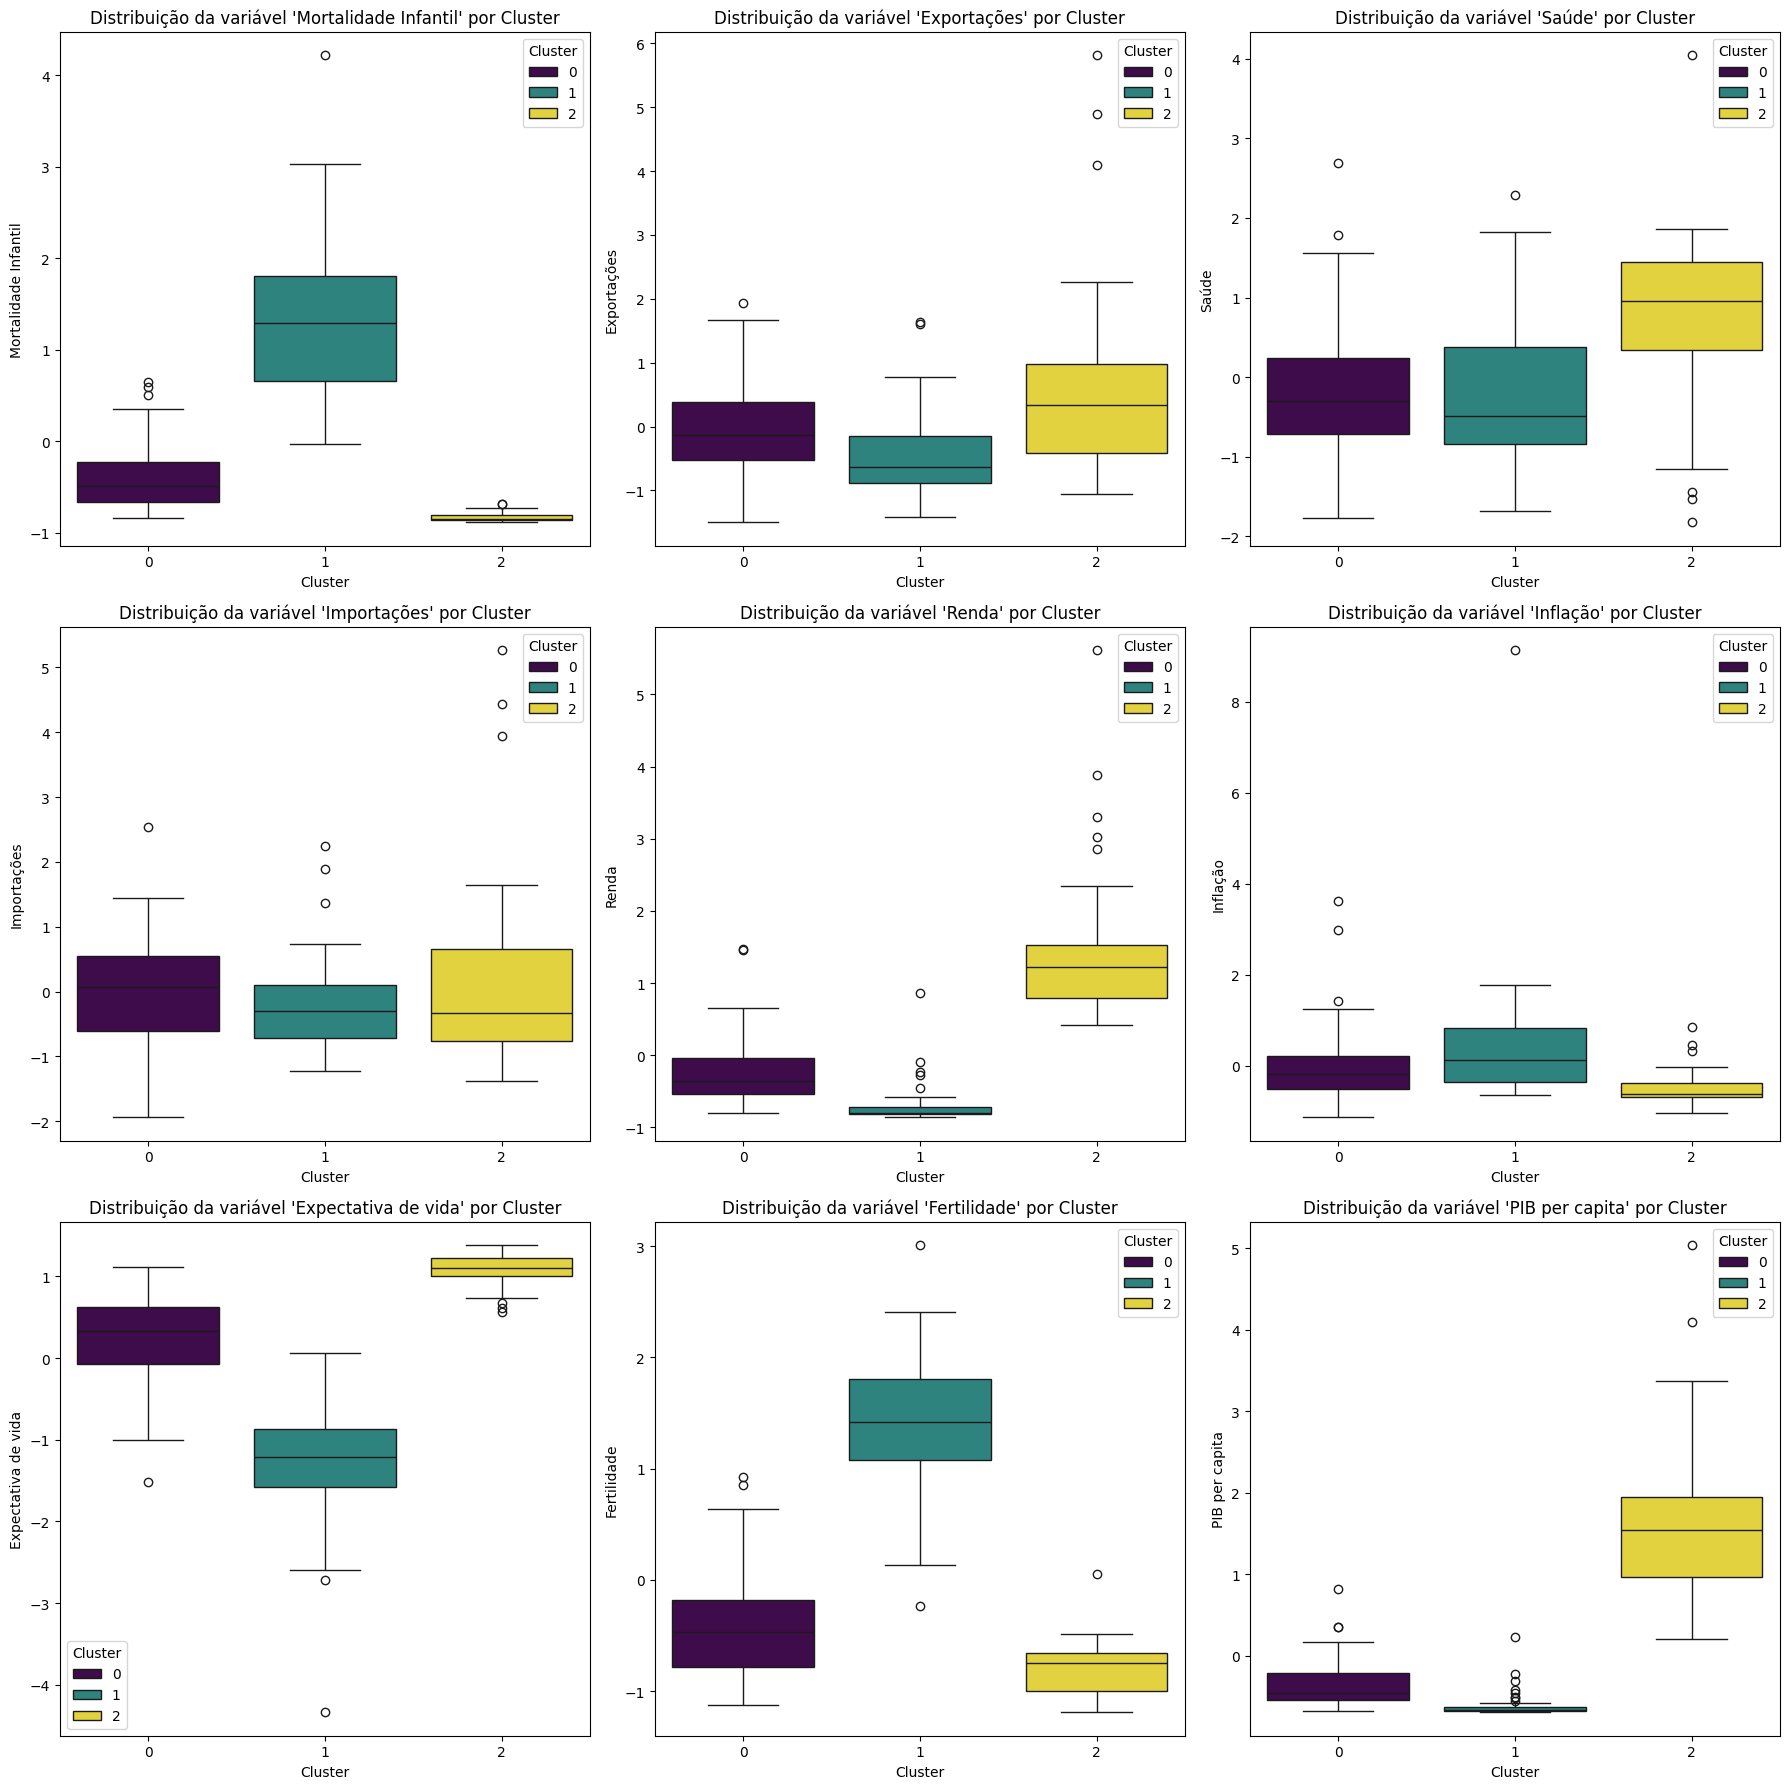

In [22]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# criando boxplots para todas as variáveis numéricas
for i in range(3):  
    for j in range(3):  
        ax = axes[i, j]  
        #selecionando a coluna específica
        coluna = dataset_tratado.columns[i * 3 + j]  
        sns.boxplot(
            data=dataset_tratado.assign(Cluster=clusters_paises['Agrupamento']),
            x='Cluster', 
            y=coluna,
            palette="viridis",
            ax=ax,
            hue='Cluster',  
        )
        ax.set_title(f"Distribuição da variável '{coluna}' por Cluster")
        ax.set_xlabel("Cluster")
        ax.set_ylabel(coluna)

# ajustando espaçamento para não sobrepor títulos e labels
plt.tight_layout()
plt.show()

Com esses gráficos podemos visualizar melhor a categorização de cada cluster entre economia emergente, em vulnerabilidade e avançada. Conseguimos também observar as variáveis que tem maior influência nessa clusterização (alto grau de separação entre os clusters), como expectativa de vida, renda e mortalidade infantil. 

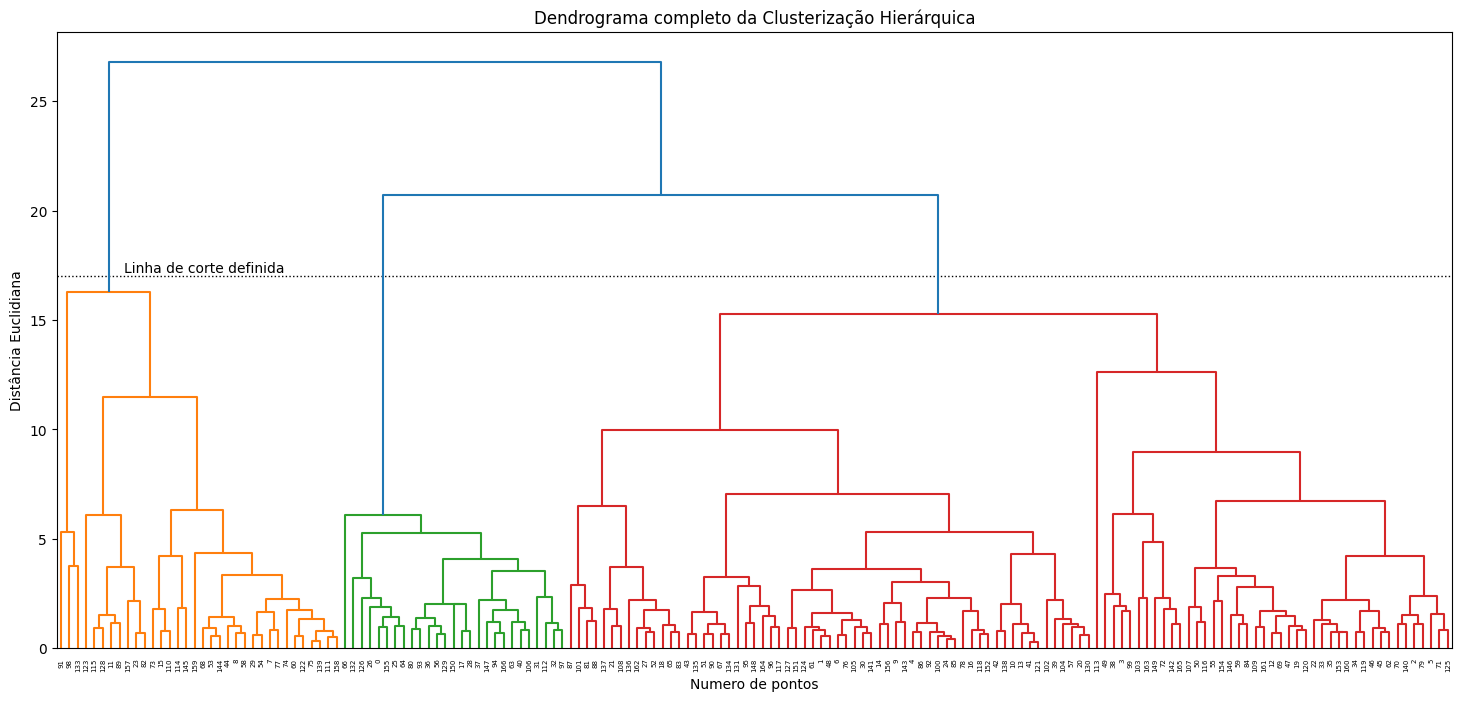

In [23]:
# definindo o plot do dendograma da clusterização hierarquica
def plot_dendrogram(model, **kwargs):

    # inicializando a array para contar os filhos em cada nó
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    # Iterar sobre os nós da árvore e calcular os filhos de forma eficiente
    for i, (left_child, right_child) in enumerate(model.children_):
        left_count = 1 if left_child < n_samples else counts[left_child - n_samples]
        right_count = 1 if right_child < n_samples else counts[right_child - n_samples]
        counts[i] = left_count + right_count

    # matriz de linkage
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # retorno
    return dendrogram(linkage_matrix, **kwargs)

# realizando a clusterização hierarquica
clusterizacao_hierarquica = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward', compute_distances=True)
model = clusterizacao_hierarquica.fit(dataset_tratado)

# plotando o dendograma
plt.figure(figsize=(18, 8))
plt.title('Dendrograma completo da Clusterização Hierárquica')
plt.ylabel('Distância Euclidiana')
plt.xlabel("Numero de pontos")
plt.hlines(y=17,xmin=0,xmax=2000,lw=1,linestyles='dotted',colors='black' )
plt.text(x=80,y=17.2,s='Linha de corte definida',fontsize=10)
dendro=plot_dendrogram(model)
plt.show()

Algo muito interessante que pode ser aferido deste gráfico, que já era uma impressão no Kmeans se torna bem mais evidente com o dendograma, é que a distância entre os países emergentes e os países com economia vulnerável é menor do que a entre os emergentes e os com economia avançada.

In [24]:
cluster_resultado = clusterizacao_hierarquica.fit_predict(dataset_tratado)

# criando o DataFrame com o resultado da clusterização
resultado_hierarquico = pd.DataFrame(cluster_resultado)
resultado_hierarquico = resultado_hierarquico.rename(columns={0: 'Agrupamento'})                       
resultado_hierarquico['Pais'] = dataset['País']

# ordenando o DataFrame pelos valores do grupo
resultado_hierarquico = resultado_hierarquico.sort_values(by='Agrupamento')

# exibindo o DataFrame com o resultado da clusterização hierárquica
pd.set_option('display.max_rows', None)
print(resultado_hierarquico)

     Agrupamento                            Pais
7              0                       Australia
15             0                         Belgium
11             0                         Bahrain
8              0                         Austria
29             0                          Canada
23             0                          Brunei
60             0                          Greece
44             0                         Denmark
54             0                          France
53             0                         Finland
58             0                         Germany
77             0                           Japan
73             0                         Ireland
74             0                          Israel
75             0                           Italy
68             0                         Iceland
82             0                          Kuwait
98             0                           Malta
111            0                     New Zealand
110            0    

In [25]:
# diferente do KMeans, na clusterização hierárquica os países com economia avançada foram agrupados em 0, os com economia emergente em 1,
# e Economias em Vulnerabilidade foram o número 2

# convertendo os valores numéricos para o mesmo significado semântico
resultado_hierarquico_comparativo = resultado_hierarquico.replace({0: 2, 1: 0, 2: 1})

# criando uma df unificada e fazendo a comparação entre as colunas
comparacao_clusterizacao = resultado_hierarquico_comparativo.sort_values(by='Pais')
comparacao_clusterizacao['K-means'] = clusters_paises.sort_values(by='Pais')['Agrupamento'].tolist()
comparacao_clusterizacao['Hierárquica'] = resultado_hierarquico_comparativo.sort_values(by='Pais')['Agrupamento'].tolist()
resultado_comparativo = comparacao_clusterizacao[['Pais', 'K-means', 'Hierárquica']]

pd.set_option('display.max_rows', None)
print(resultado_comparativo)

# checando o % de similaridade entre os métodos
similaridades = comparacao_clusterizacao['K-means'] == comparacao_clusterizacao["Hierárquica"]
total_similaridades = similaridades.sum()

print('-' * 60)
print(f'Os métodos de clusterização tiveram o mesmo resultado em {100*total_similaridades/len(dataset)}% dos casos')


                               Pais  K-means  Hierárquica
0                       Afghanistan        1            1
1                           Albania        0            0
2                           Algeria        0            0
3                            Angola        1            0
4               Antigua and Barbuda        0            0
5                         Argentina        0            0
6                           Armenia        0            0
7                         Australia        2            2
8                           Austria        2            2
9                        Azerbaijan        0            0
10                          Bahamas        0            0
11                          Bahrain        2            2
12                       Bangladesh        0            0
13                         Barbados        0            0
14                          Belarus        0            0
15                          Belgium        2            2
16            

Ambos os métodos classificaram 84% dos países no mesmo cluster, mostrando uma convergência razoavel entre os modelos, enquanto nos demais casos discordaram.

# PARTE 4 - Escolha de algoritmos

### As etapas do algoritmo de K-means até sua convergência:

- Após a escolha da quantidade de clusters, uma mesma quantidade de pontos são escolhidos aleatoriamente para serem os centroides iniciais da iteração. Essa escolha dos centroides iniciais pode ser realizada de outras formas (K-means++).

- Para cada um dos dados é calculada a distância (que pode ser euclidiana, dentre outras opções) para o centroide, e o dado é atribuido ao cluster com o centroide mais perto

- Após todos os dados terem sido atribuídos, um novo centroide é determinado com base na média da posição de todos os pontos do seu cluster

- Estes passos são repetidos até que o centroide da próxima iteração seja satisfatoriamente igual ao atual, quando ocorre então a convergência

### As etapas do algoritmo de K-medoid até sua convergência:

- Similarmente, após a definição da quantidade de clusters, uma mesma quantidade de dados é escolhida para que sejam os medoides iniciais da iteração.

- Novamente, para cada um dos dados é calculada a distância (que pode ser euclidiana, dentre outras opções) para o medoide, e o dado é atribuido ao cluster com o medoide mais perto

- Após todos os dados terem sido atribuídos, um novo ponto é analisado como medoide e as distâncias são novamente medidas. Caso elas sejam menor com ele, ele é o novo medoide deste cluster.

- Este passo é repetido até que o medoide atual seja o que mais adequado para o cluster em questão.

In [26]:
# realizando a clusterização pelo método de Kmedoides, com init = 'k-medoids++' para obter melhores resultados
kmedoide = KMedoids(n_clusters=3, random_state=99, init='k-medoids++') 
kmedoide.fit(dataset_tratado)

grupos_kmedoide = kmedoide.predict(dataset_tratado)
resultado_kmedoide = pd.DataFrame(grupos_kmedoide)


# nomeando a coluna de agrupamento, e colocando novamente os países na dataframe
resultado_kmedoide = resultado_kmedoide.rename(columns={0: 'Agrupamento'})                       
resultado_kmedoide['Pais'] = dataset['País']

# printando os resultados 
resultado_kmedoide = resultado_kmedoide.sort_values(by='Agrupamento')
pd.set_option('display.max_rows', None)
print(resultado_kmedoide)



     Agrupamento                            Pais
0              0                     Afghanistan
3              0                          Angola
31             0        Central African Republic
28             0                        Cameroon
25             0                    Burkina Faso
26             0                         Burundi
21             0                        Botswana
17             0                           Benin
49             0               Equatorial Guinea
50             0                         Eritrea
55             0                           Gabon
40             0                   Cote d'Ivoire
36             0                         Comoros
37             0                Congo, Dem. Rep.
38             0                     Congo, Rep.
32             0                            Chad
59             0                           Ghana
63             0                          Guinea
56             0                          Gambia
107            0    

In [27]:

# Para o KMedoides, separamos os clusters da seguinte forma para um resultado semântico semelhante 
#    0: "Economias Em vulnerabilidade",
#    1: "Economias Avançada",
#    2: "Economias Emergentes"

nomes_grupos_kmedoide = {
    0: "Economias Em vulnerabilidade",
    1: "Economias Avançada",
    2: "Economias Emergentes"
}

# obtendo o valor de cada variável do medóide
medoides = kmedoide.cluster_centers_
print(f'Os valores de cada variável do medóides são: \n{medoides}')

# obtendo o país que representa o medóide de cada cluster
indices_medoides = kmedoide.medoid_indices_
print(indices_medoides)
paises_medoides = dataset['País'].iloc[indices_medoides]
clusters_medoides = pd.Series(range(len(indices_medoides)), name="Agrupamento")

# Criando um DataFrame com os resultados
df_medoides = pd.DataFrame({
    "Agrupamento": clusters_medoides.map(nomes_grupos_kmedoide),
    "País": paises_medoides.values
})

# Exibindo o resultado
print("-" * 60)
print(f"Os países que representam o medóide de cada cluster são:\n{df_medoides}")




Os valores de cada variável do medóides são: 
[[ 0.83639913 -0.81994613 -0.29419715 -0.73705173 -0.78327176  0.13930796
  -1.26946162  1.64448575 -0.67102583]
 [-0.84983227  0.30336919  0.04174079 -0.02859573  0.68965299 -0.43854531
   1.07644564 -1.13824599  0.49994371]
 [-0.50164289 -0.35891118 -0.73237706  0.11226687 -0.47578376  0.19244389
   0.46741203 -0.51544412 -0.45333648]]
[147 138  76]
------------------------------------------------------------
Os países que representam o medóide de cada cluster são:
                    Agrupamento         País
0  Economias Em vulnerabilidade     Tanzania
1            Economias Avançada  South Korea
2          Economias Emergentes      Jamaica


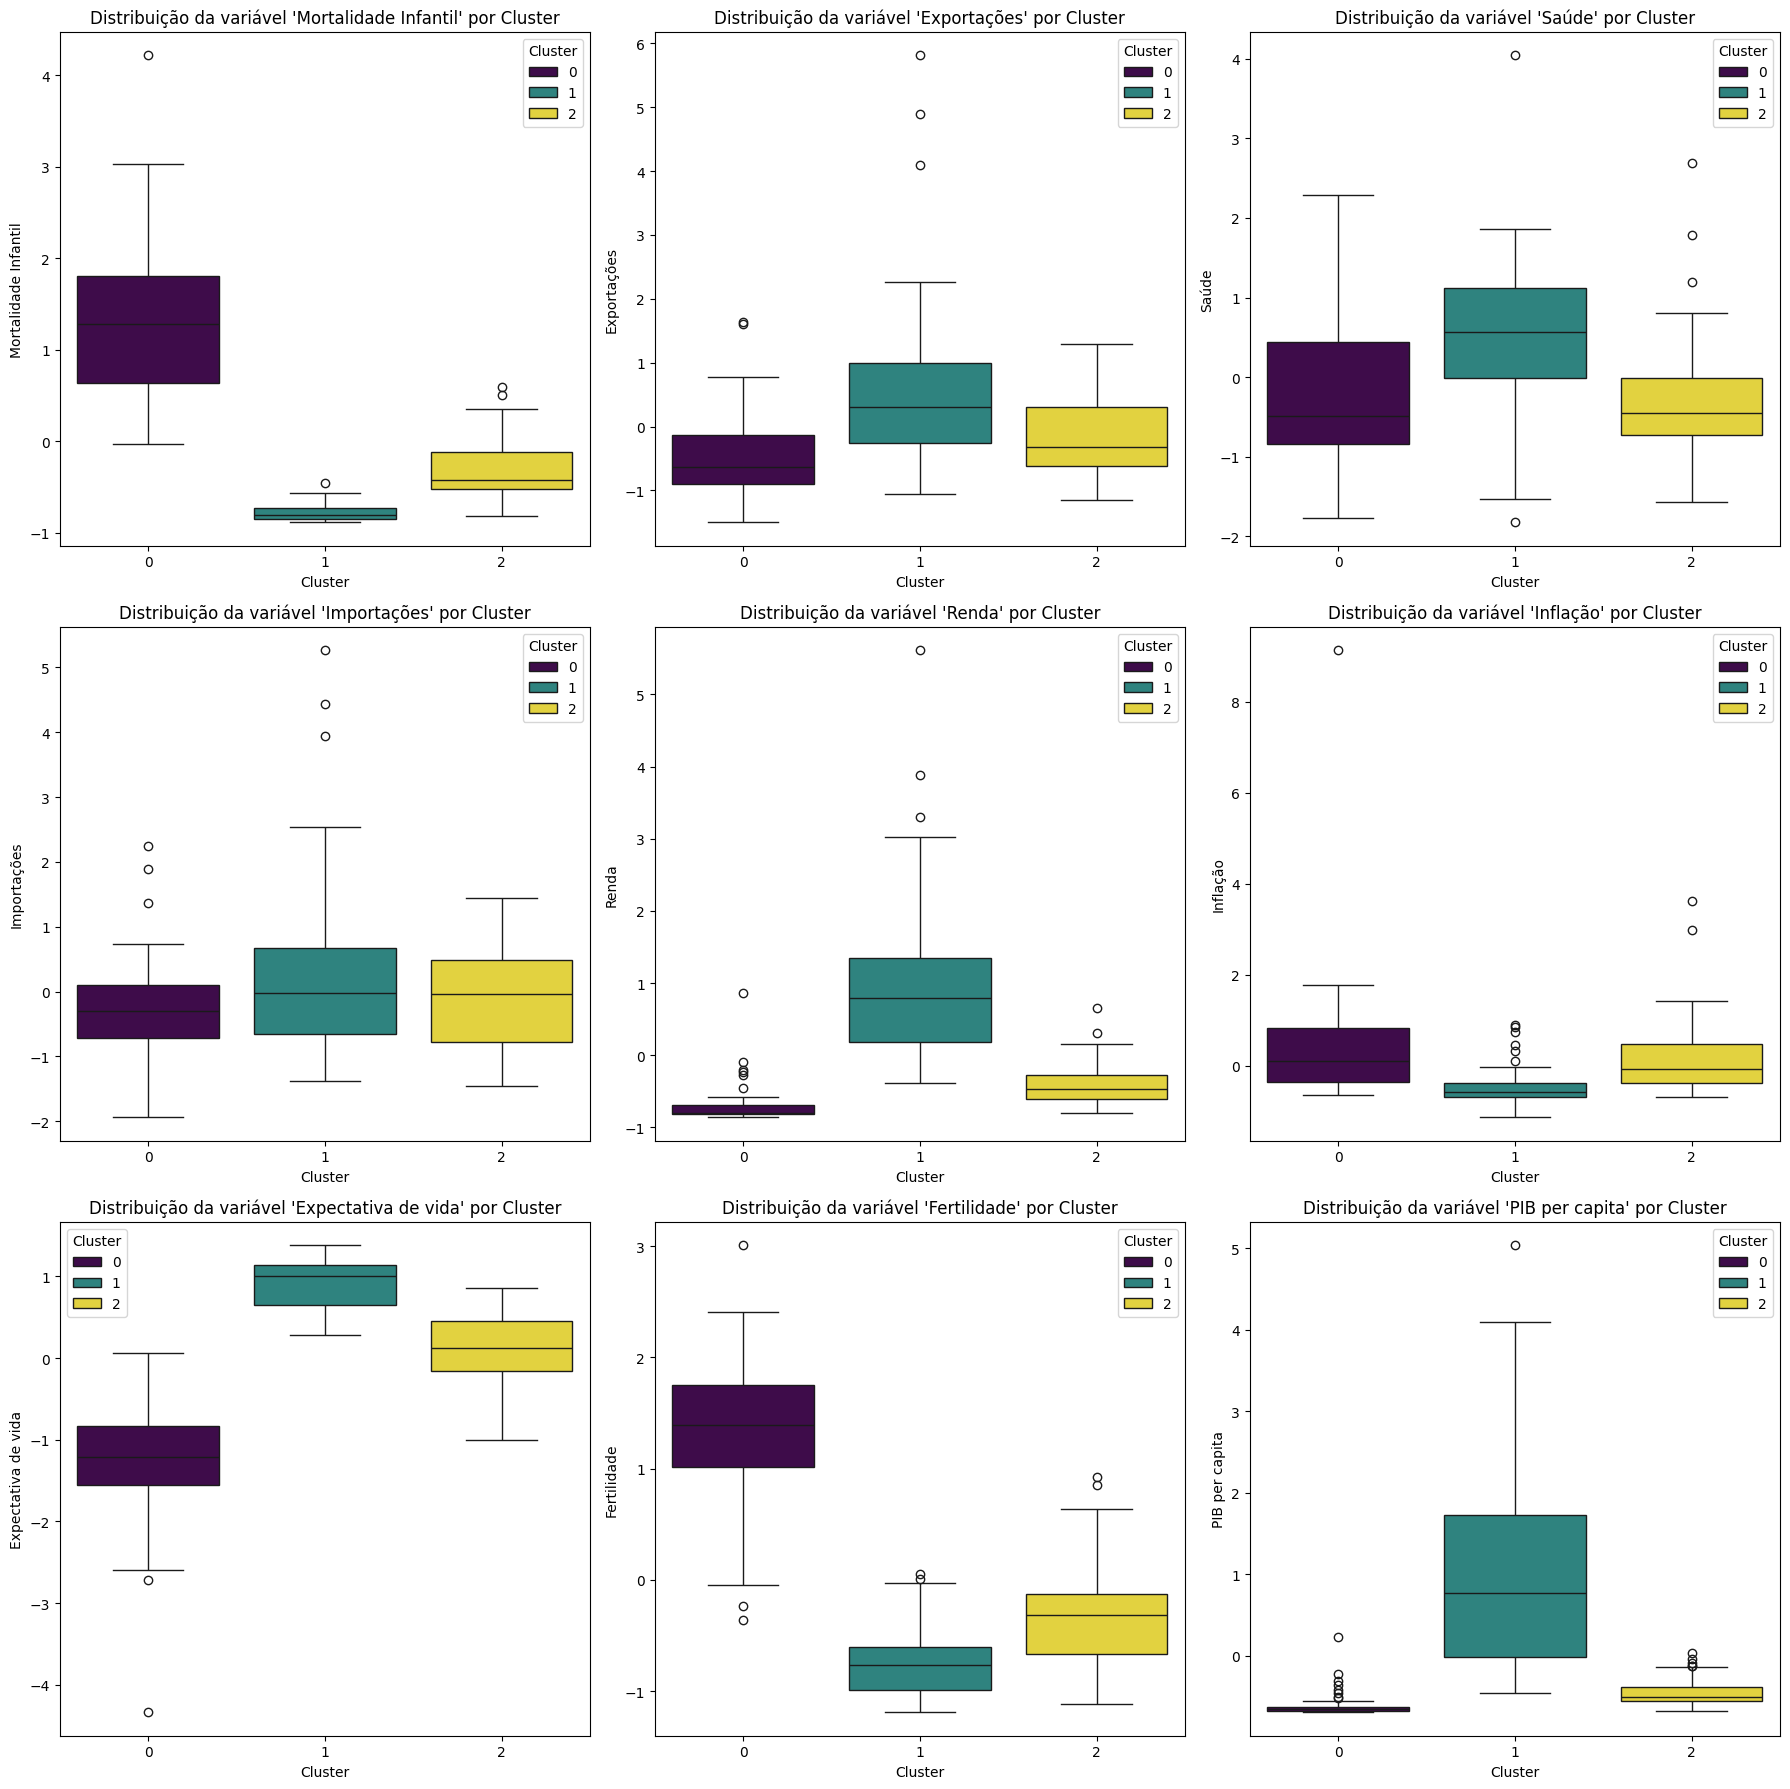

In [28]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# criando boxplots para todas as variáveis numéricas
for i in range(3):  
    for j in range(3):  
        ax = axes[i, j]  
        #selecionando a coluna específica
        coluna = dataset_tratado.columns[i * 3 + j]  
        sns.boxplot(
            data=dataset_tratado.assign(Cluster=resultado_kmedoide['Agrupamento']),
            x='Cluster', 
            y=coluna,
            palette="viridis",
            ax=ax,
            hue='Cluster',  
        )
        ax.set_title(f"Distribuição da variável '{coluna}' por Cluster")
        ax.set_xlabel("Cluster")
        ax.set_ylabel(coluna)

# ajustando espaçamento para não sobrepor títulos e labels
plt.tight_layout()
plt.show()

### Sensibilidade de K-means e K-medoids a outliers

A média de um grupo de dados depende do valor específico de cada um deles, enquanto a mediana de um grupo depende apenas de quantos elementos são maiores e quantos são menores do que o valor central. Logo, a extrapolação de um desses valores externos para um extremo, vai alterar apenas a média mas não a médiana. Por definição, o K-means se baseia nas médias, enquanto o K-medoids se baseia nas medianas. Para uma visualização exagerada, tendo um conjunto de dados [2, 2, 5, 6, 30], a média será 9, enquanto a mediana é 5, note que a média é maior do que todos os números desse conjunto, à excessão do nosso outlier. Se, no lugar do 30 tivessemos um número ainda maior, como 3000, esse fenômeno seria ainda mais exarcebado. 

Portanto, o K-means é sensível à outliers por ser definido a partir das médias (centroides) dos pontos.

### Robustez do DBScan à presença de outliers

O DBScan (Density-Based Spatial Clustering of Applications with Noise) já indica no próprio nome um dos motivos de ser melhor preparado para tratar de outliers. Por ser um método baseado em densidades de pontos, e não nas distâncias médias discutidas anteriormente, o DBScan identifica as regiões de cada cluster com base nas  pontos que estão fora da densidade todos clusters ao mesmo tempo são identificados como ruídos. Portanto, por ignorar pontos que não estão em regiões densas, são, por definição, altamente resistente à outliers.